# Wind_Energy_Power_Analysis

Climate change is a global problem which requires actions to be taken globally. The effects of climate change resulting from the increased levels of greenhouse gas emissions in the atmosphere are becoming increasingly visible. In order to reduce these impacts and prevent the climate crisis, countries have commenced developing climate-neutral policies by focusing on clean technologies.[1](https://shura.org.tr/en/net-zero-2053-energy-sector-policies/)

Wind power; is a natural, renewable, clean, and infinite power and its source is the sun. A small amount of 1-2% of the energy that the sun sends to the earth turns into wind energy. Airflow occurs due to the difference in temperature and pressure that occurs as a result of the sun not heating the ground surface and atmosphere homogeneously.[2](https://enerji.gov.tr/eigm-resources)

A wind turbine is a device that converts the kinetic energy of wind into electrical energy. As of 2020, hundreds of thousands of large turbines, in installations known as wind farms, were generating over 650 GW of power, with 60 GW added each year.[3](https://wwindea.org/world-wind-capacity-at-650-gw)

Wind power generates about 10% of Turkey's electricity, mainly in the west in the Aegean and Marmara regions, and is gradually becoming a larger share of renewable energy in the country. As of 2024, Turkey has 12 gigawatts (GW) of wind turbines. The Energy Ministry plans to have almost 30 GW by 2035, including 5 GW offshore.

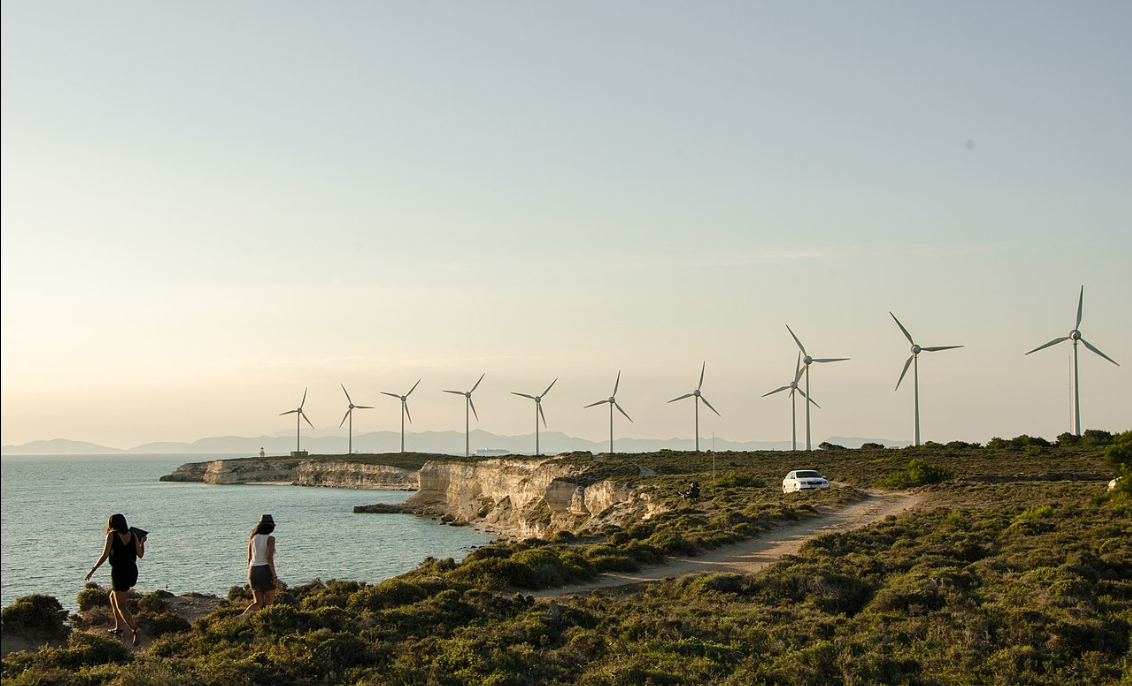
[source](https://en.wikipedia.org/wiki/Wind_power_in_Turkey#/media/File:Wind_turbines_in_Imbros.jpg)

# Business Problem

The Turkey Ministry of Energy and Natural Resources is responsible for ensuring the country's energy security, promoting sustainable energy development, and supporting the integration of renewable energy sources into the national grid. Wind power is a significant component of Turkey's renewable energy strategy due to its abundant wind resources. Accurate prediction of wind power generation is crucial for effective energy planning, grid stability, and optimizing the integration of renewable energy.es.


The Ministry of Energy and Natural Resources needs a reliable method to accurately predict wind power generation on an hourly basis. 
This prediction is essential for:
- __Grid Stability__ : Ensuring a stable and balanced power grid by effectively managing the variability of wind power.
- __Energy Trading__: Making informed decisions about energy trading in local and international markets.
- __Resource Allocation__: Optimizing the allocation of energy resources, including the balance between renewable and non-renewable energy sources.

In [1]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


Import all required python libraries for time series analysis.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, RegressorMixin
import warnings
warnings.simplefilter("ignore")

In [3]:
# Read the dataset from the data folder
df = pd.read_csv(r'data\T1.csv')

In [4]:
# Display the first five rows
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [5]:
# Display concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
# Display descriptive statistics
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [7]:
df1 = pd.read_csv(r'data\T1.csv')

In [8]:
# Change the dtype for Date\Time column from object to datetime frame
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format ='%d %m %Y %H:%M')

In [9]:
# Adding more columns from Date\Time 
df['Month'] = df['Date/Time'].dt.month
df['Week'] = df['Date/Time'].dt.day//7+1
df['Day'] = df['Date/Time'].dt.day
df['Hour'] = df['Date/Time'].dt.hour+1

In [10]:
# Create Seasons column
dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer',
        8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
df['Seasons'] = df['Month'].map(dict)

In [11]:
# Set Date/Time column as index for the dataframe for time series analysis
df.index = df['Date/Time']
del df['Date/Time']

In [12]:
df.head(5)

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Week,Day,Hour,Seasons
Date/Time,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,1,Winter
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,1,Winter
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,1,Winter
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,1,Winter
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,1,Winter


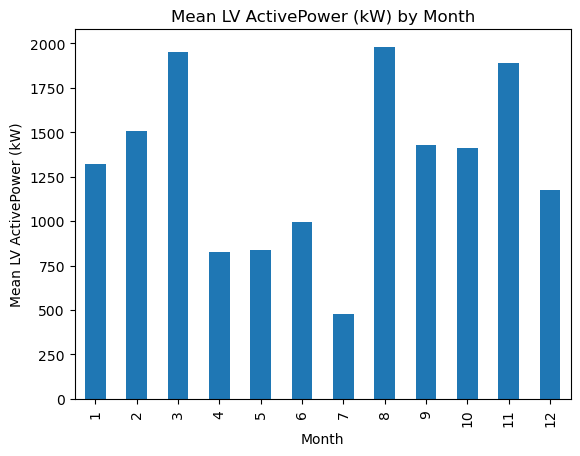

In [13]:
# Plotting the average monthly power output 
Monthly_power = df.groupby('Month')['LV ActivePower (kW)'].mean().plot(kind = 'bar')
plt.xlabel('Month')
plt.ylabel('Mean LV ActivePower (kW)')
plt.title('Mean LV ActivePower (kW) by Month')
plt.show()

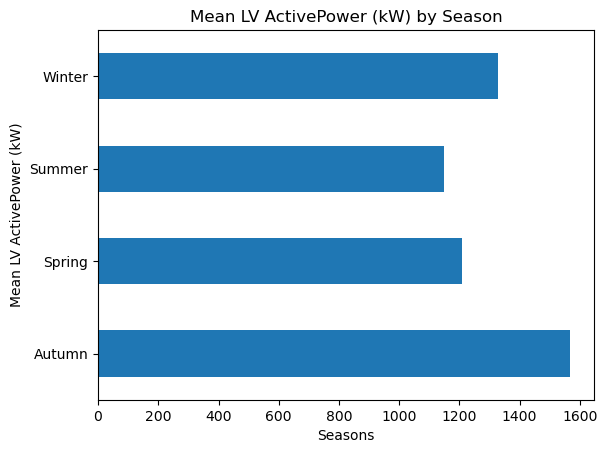

In [14]:
# Plotting the average seasonal power output
Seasonal_power = df.groupby('Seasons')['LV ActivePower (kW)'].mean().plot(kind = 'barh')
plt.xlabel('Seasons')
plt.ylabel('Mean LV ActivePower (kW)')
plt.title('Mean LV ActivePower (kW) by Season')
plt.show()

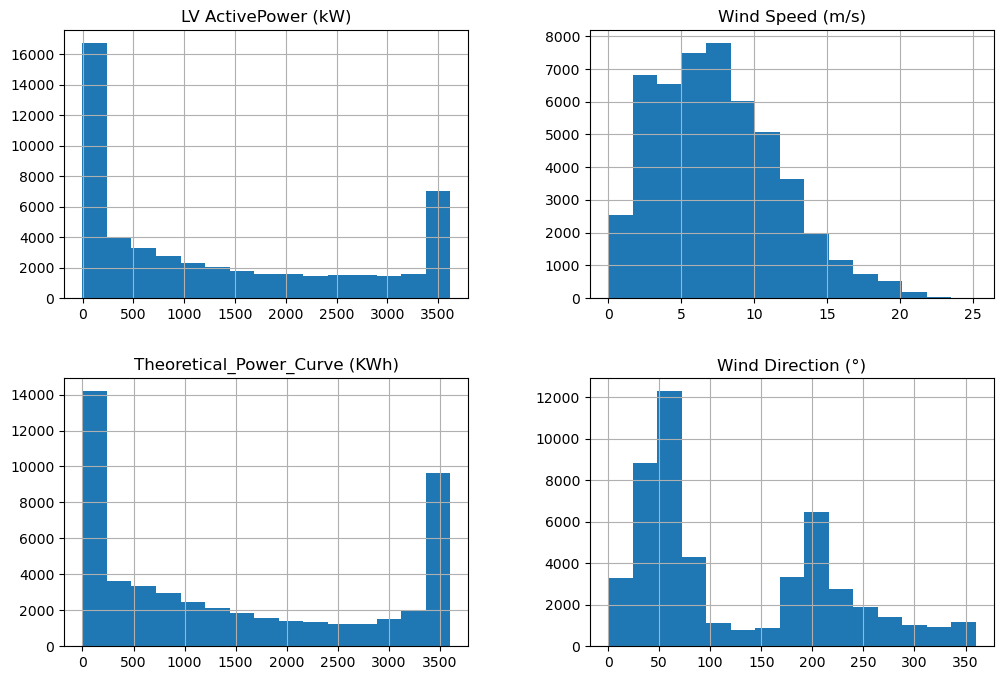

In [15]:
# Histogram for each numerical columns
num_col = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
df[num_col].hist(bins = 15 , figsize = (12,8))
plt.show()

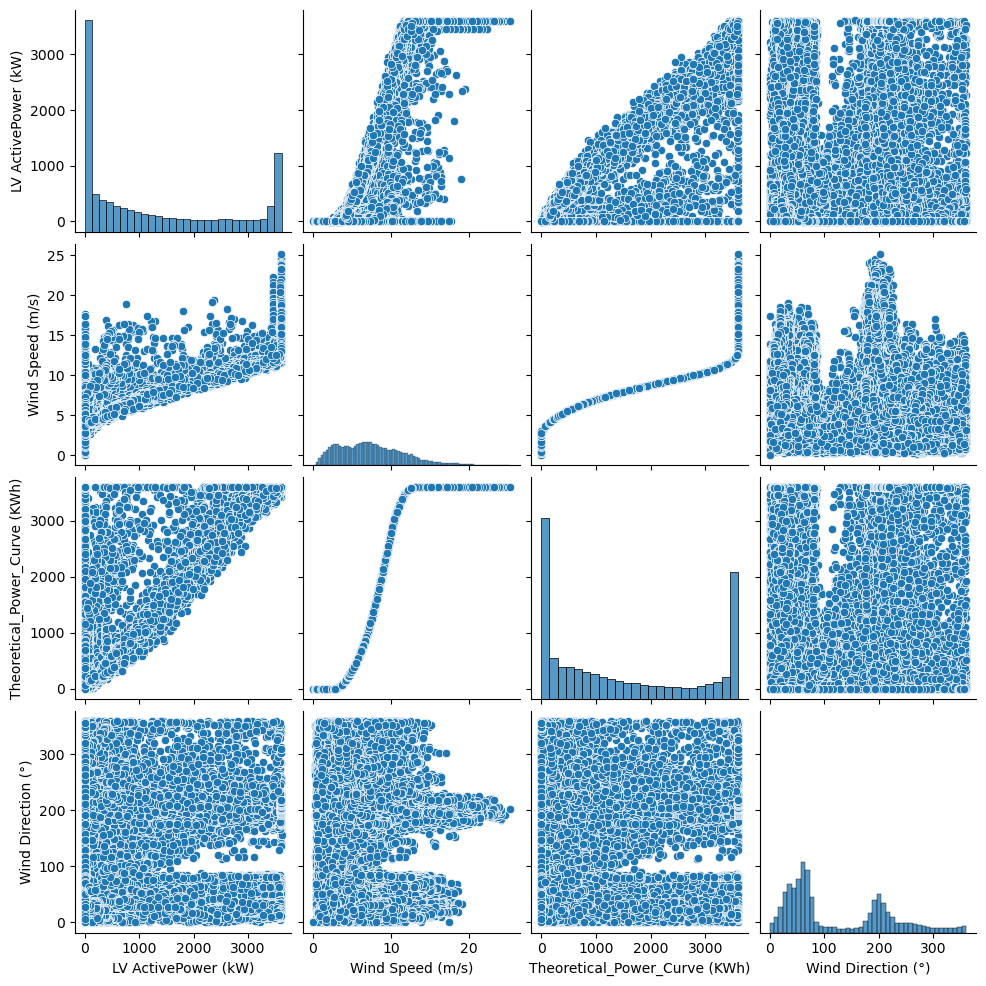

In [16]:
# Plotting Pairplot to see some correlation between features. 
sns.pairplot(df[num_col])
plt.show()

- From the scatter plot of wind speed versus the theoretical power curve, we observe that wind turbine systems are unable to generate any power when the wind speed is between 0 and 4 m/s.
- When the wind speed ranges from 4 m/s to 11 m/s, there is a linear relationship between wind speed and power generation, meaning that as the wind speed increases, the turbines generate more power.
- Once the wind speed exceeds 11 m/s, the power generated levels off at 3600 kWh.

In [17]:
# Filtering all records with out power 
filtered_df = df[df['LV ActivePower (kW)'] <= 0]
filtered_df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Week,Day,Hour,Seasons
Date/Time,,,,,,,,,
2018-01-03 15:40:00,0.000000,3.743307,83.986265,245.068207,1,1,3,16,Winter
2018-01-03 16:00:00,-0.393068,2.185888,0.000000,238.410294,1,1,3,17,Winter
2018-01-03 16:10:00,0.000000,2.142016,0.000000,234.762405,1,1,3,17,Winter
2018-01-03 16:20:00,0.000000,2.501406,0.000000,223.308807,1,1,3,17,Winter
2018-01-03 16:30:00,0.000000,2.668578,0.000000,226.051697,1,1,3,17,Winter


In [18]:
# Drop negative and zero LV Activepower 
df.drop(filtered_df.index , inplace =True )

In [19]:
# Check for null values
df.isna().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Month                            0
Week                             0
Day                              0
Hour                             0
Seasons                          0
dtype: int64

In [20]:
# Check correlation between columns
corr_matrix = df[num_col].corr()
corr_matrix

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
LV ActivePower (kW),1.000000,0.928406,0.974316,0.034720
Wind Speed (m/s),0.928406,1.000000,0.930786,0.068609
Theoretical_Power_Curve (KWh),0.974316,0.930786,1.000000,0.004682
Wind Direction (°),0.034720,0.068609,0.004682,1.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39692 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LV ActivePower (kW)            39692 non-null  float64
 1   Wind Speed (m/s)               39692 non-null  float64
 2   Theoretical_Power_Curve (KWh)  39692 non-null  float64
 3   Wind Direction (°)             39692 non-null  float64
 4   Month                          39692 non-null  int32  
 5   Week                           39692 non-null  int32  
 6   Day                            39692 non-null  int32  
 7   Hour                           39692 non-null  int32  
 8   Seasons                        39692 non-null  object 
dtypes: float64(4), int32(4), object(1)
memory usage: 2.4+ MB


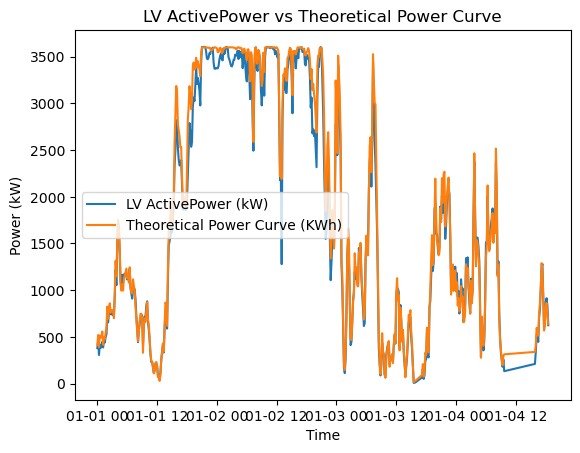

In [22]:
# Plot active power vs theoretical power
sns.lineplot(data=df[:500], x=df.index[:500], y='LV ActivePower (kW)', label='LV ActivePower (kW)')
sns.lineplot(data=df[:500], x=df.index[:500], y='Theoretical_Power_Curve (KWh)', label='Theoretical Power Curve (KWh)')
plt.title('LV ActivePower vs Theoretical Power Curve')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

For time series analysis we mainly need two things, each data point must have a timestamp that accurately reflects the time at which the observation was made which is Date/Time in our case and target in this case LV Activepower. 

In [23]:
df_copy = df[['LV ActivePower (kW)']]

In [24]:
df_copy.head()

,LV ActivePower (kW)
Date/Time,
2018-01-01 00:00:00,380.047791
2018-01-01 00:10:00,453.769196
2018-01-01 00:20:00,306.376587
2018-01-01 00:30:00,419.645905
2018-01-01 00:40:00,380.650696


### Train test split and Data preprocessing
Unlike other types of machine learning models where random splitting is common, time series data must maintain temporal order. The training set should consist of the earlier data, and the test set should be the more recent data.

In [25]:
# Train test split , test_size = 0.2
train = df_copy['LV ActivePower (kW)'][:31755]
test = df_copy['LV ActivePower (kW)'][31755:]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
train_scaled_Base = scaler.fit_transform(train.values.reshape(-1, 1))

# Transform the test data using the same scaler
test_scaled_Base = scaler.transform(test.values.reshape(-1, 1))

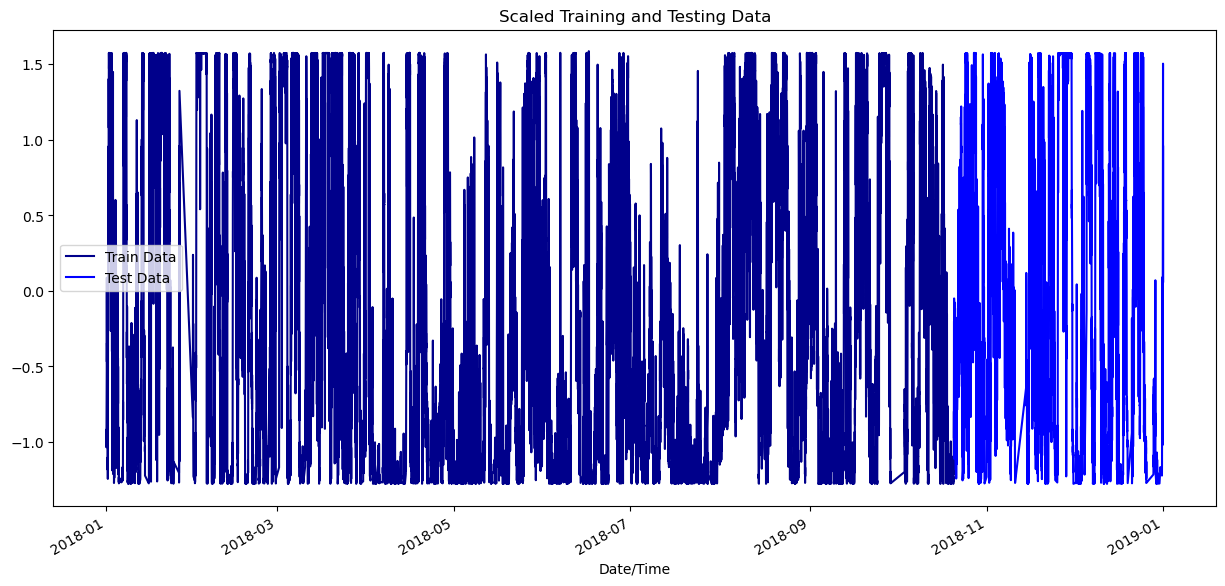

In [26]:
# Convert the scaled data back to Pandas Series for plotting
train_scaled_series = pd.Series(train_scaled_Base.flatten(), index=train.index)
test_scaled_series = pd.Series(test_scaled_Base.flatten(), index=test.index)

# Plot the scaled training and testing data
plt.figure(figsize=(15, 7))
train_scaled_series.plot(color='darkblue', label='Train Data')
test_scaled_series.plot(color='blue', label='Test Data')
plt.title('Scaled Training and Testing Data')
plt.legend()
plt.show()

 ### Seasonal Decompositiony.

 Seasonal decomposition in time series analysis is a crucial technique used to separate a time series into its fundamental components.
 
- __Trend__: The long-term movement or direction in the data, indicating the general tendency of the series (e.g., upward, downward).
- __Seasonality__: Regular, repeating patterns or cycles in the data that occur at fixed intervals (e.g., daily, monthly, yearly).
- __Residual (or Irregular)__: The random noise or irregular component, which represents the fluctuations that cannot be attributed to trend or seasonality.

To show the seasonal decomposition clearly I limited the dataset to 100 records only.

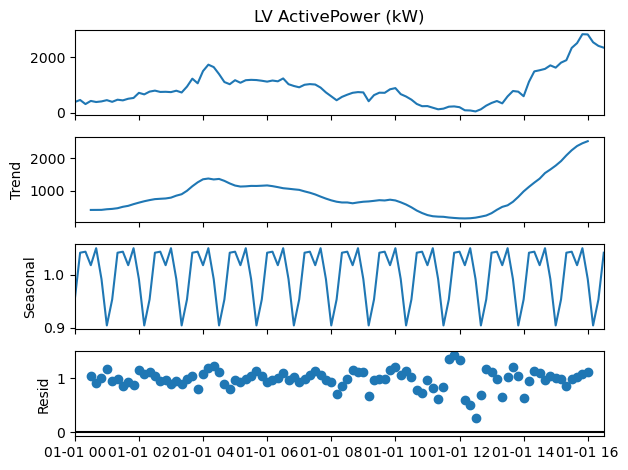

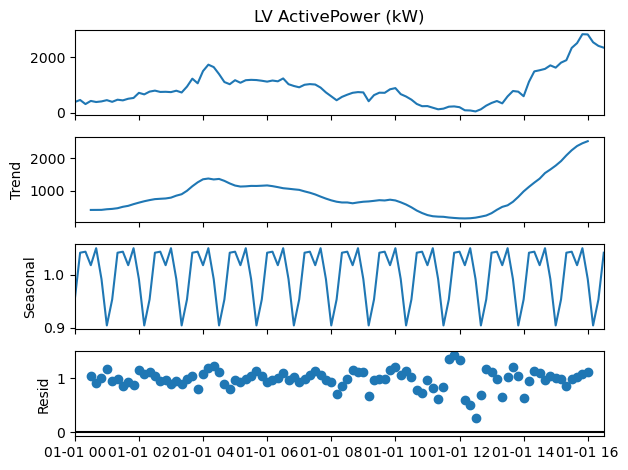

In [27]:
# Now you can perform seasonal decomposition
import statsmodels.api as sm
result = sm.tsa.seasonal_decompose(df_copy['LV ActivePower (kW)'][:100], model='multiplicative',period = 7)

# Plot the decomposed components
result.plot()

### Checking Stationarty

Stationary Data: A stationary time series has properties that do not depend on the time at which the series is observed. This includes constant mean, variance, and autocorrelation over time. Many time series analysis techniques assume stationarity. If the data is not stationary, transformations such as differencing or detrending might be necessary. To check the stationarity of time series data, a commonly used statistical test is the Augmented Dickey-Fuller (ADF) test. 


In [28]:
# Here is the code used to check weather the data is staionary or not
adfuller(train,autolag='AIC')

(-12.34772961205112,
 5.920126800842109e-23,
 31,
 31723,
 {'1%': -3.4305561541853486,
  '5%': -2.861631114759248,
  '10%': -2.566818497574244},
 444324.71895748517)

Based on the ADF test our dataset is stationary. Since the P-value = 5.92*10^-23 is very small number compare to 0.05 that means we are 95% confidence the data is stationary.

Autocorrelation and partial autocorrelation are fundamental concepts in time series analysis, crucial for understanding the internal structure of the data. They help in identifying and quantifying the dependencies between observations at different time lags, which is essential for model selection and diagnostics.

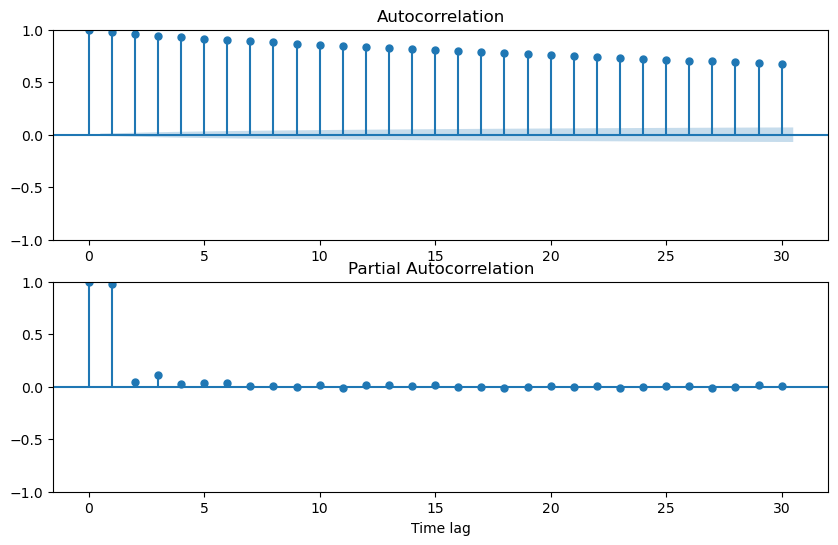

In [29]:
#Analysis of ACF and PACF on active power
import statsmodels.api as sm
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_scaled_Base, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_scaled_Base, lags=30, ax=ax2)
plt.xlabel('Time lag')
plt.show()

#### Interpretation

- __ACF Plot__: Shows the correlation of the time series with its own lagged values. Significant spikes outside the confidence intervals indicate the presence of autocorrelation at those lags.
- __PACF Plot__: Shows the correlation of the time series with its own lagged values, controlling for the values at shorter lags. Significant spikes indicate the direct effect of those lags on the series.

### Baseline model ARIMA(2,0,1)

The parameters ARIMA(p,d,q)

- p: Captures the linear dependence on past observations.
  
- d: Ensures stationarity through differencing.
  
- q: Captures the linear dependence on past forecast errors.

In [30]:
# Initiate and fit ARIMA(2,0,1)
model_Base=ARIMA(train_scaled_Base , order=(2,0,1))
model_fit_Base=model_Base.fit()
print(model_fit_Base.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                31755
Model:                 ARIMA(2, 0, 1)   Log Likelihood                4014.183
Date:                Thu, 23 May 2024   AIC                          -8018.367
Time:                        12:28:09   BIC                          -7976.538
Sample:                             0   HQIC                         -8004.981
                              - 31755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.055     -0.013      0.990      -0.108       0.107
ar.L1          0.2248      0.097      2.322      0.020       0.035       0.415
ar.L2          0.7344      0.095      7.754      0.0

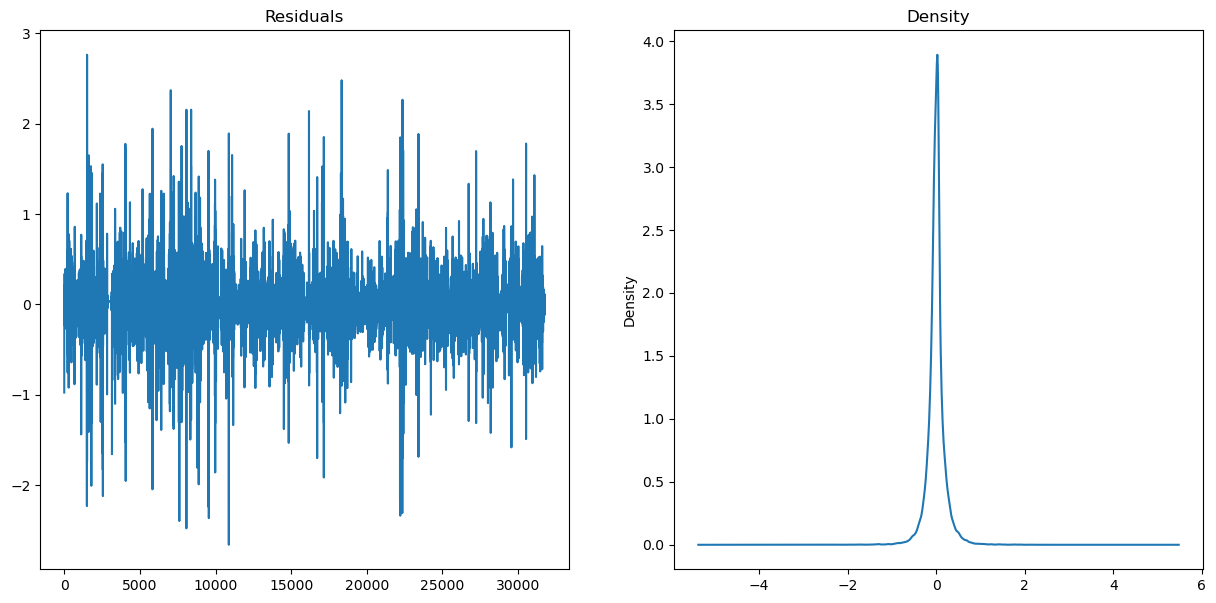

In [31]:
# Extract residuals from the fitted model
residuals = model_fit_Base.resid

# Convert residuals to Pandas Series for plotting
residuals_series = pd.Series(residuals.flatten())

# Plot the residuals and their density
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
residuals_series.plot(title='Residuals', ax=ax[0])
residuals_series.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

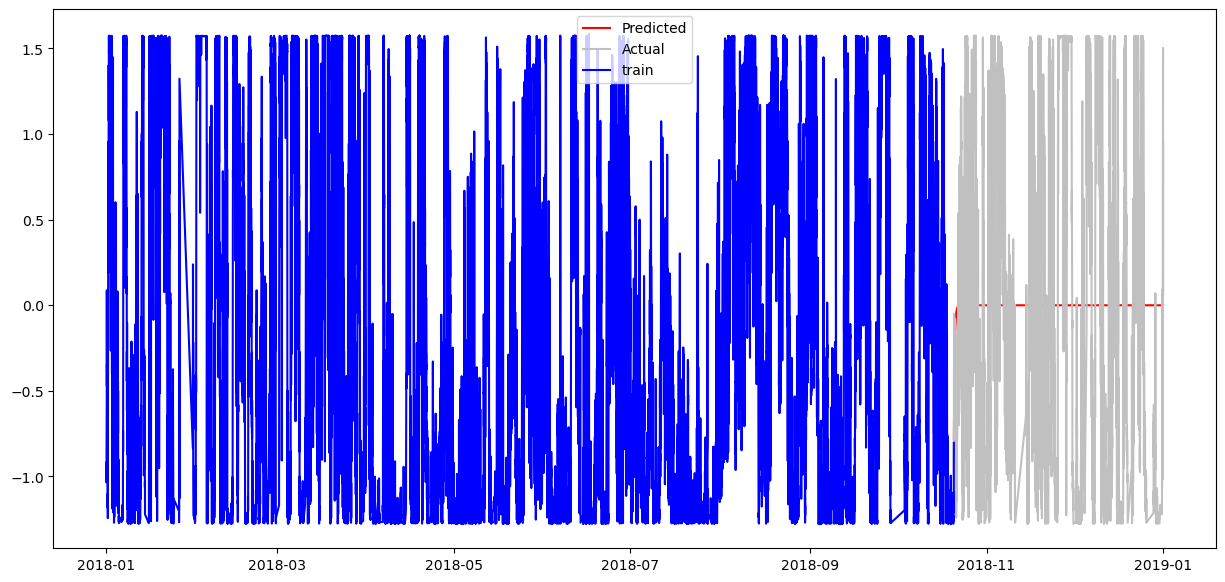

In [32]:
# Predicting values for the test data
predicted_values = model_fit_Base.forecast(steps=len(test_scaled_Base))
predicted_values_series = pd.Series(predicted_values.flatten(), index=test.index)
#train_scaled_series = pd.Series(train_scaled_Base.flatten(), index=train.index)
#test_scaled_series = pd.Series(test_scaled_Base.flatten(), index=test.index)
#predicted_values_series.index = test_scaled_series.index
# Plotting predicted and actual values
plt.figure(figsize =(15,7))
plt.plot(predicted_values_series, label='Predicted' , color ='red')
plt.plot(test_scaled_series, label='Actual', color = 'silver')
plt.plot(train_scaled_series ,label = 'train', color = 'blue')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
mae = mean_absolute_error(test_scaled_Base,predicted_values)
mape = mean_absolute_percentage_error(test_scaled_Base,predicted_values)
rmse = np.sqrt(mean_squared_error(test_scaled_Base,predicted_values))
print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae : 0.8786348205548828
mape : 0.9967202729872408
rmse : 1.002963357347606


The baseline metrics indicate a significant need for improvement

### Let us see the effect of log transformation on the baseline model

In [34]:
model_log=ARIMA(np.log (train) , order=(2,0,1))
model_log=model_log.fit()
print(model_log.summary())

                                SARIMAX Results                                
Dep. Variable:     LV ActivePower (kW)   No. Observations:                31755
Model:                  ARIMA(2, 0, 1)   Log Likelihood              -29670.356
Date:                 Thu, 23 May 2024   AIC                          59350.713
Time:                         12:28:40   BIC                          59392.542
Sample:                              0   HQIC                         59364.098
                               - 31755                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7735      0.138     49.038      0.000       6.503       7.044
ar.L1          1.3496      0.007    188.233      0.000       1.336       1.364
ar.L2         -0.3660      0.007    -55.991 

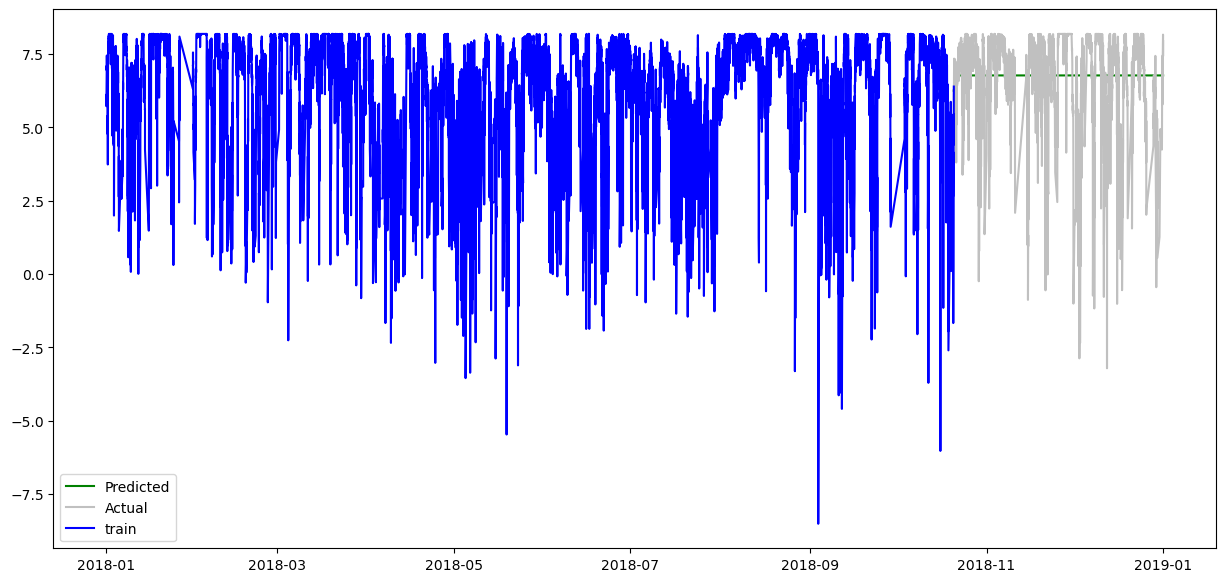

In [35]:
# Predicting values for the test data
predicted_values_log = model_log.forecast(steps=len(np.log(test)))
predicted_values_log.index = np.log(test).index
# Plotting predicted and actual values
plt.figure(figsize =(15,7))
plt.plot(predicted_values_log, label='Predicted' , color ='green')
plt.plot(np.log(test), label='Actual', color = 'silver')
plt.plot(np.log(train) ,label = 'train', color = 'blue')
plt.legend()
plt.show()

In [36]:
mae = mean_absolute_error(test,predicted_values_log)
mape = mean_absolute_percentage_error(test,predicted_values_log)
rmse = np.sqrt(mean_squared_error(test,predicted_values_log))
print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae : 1858.7618053921738
mape : 1.0481966694076679
rmse : 2236.9517851924247


The log transformation failed to enhance the metrics; it yielded poor results.

### Use smaller size of train and test on the same hyperparamater

In [37]:
# Train test split 
train_s = df_copy['LV ActivePower (kW)'][:1000]
test_s = df_copy['LV ActivePower (kW)'][1000:1020]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
train_scaled_Base_s = scaler.fit_transform(train_s.values.reshape(-1, 1))

# Transform the test data using the same scaler
test_scaled_Base_s = scaler.transform(test_s.values.reshape(-1, 1))

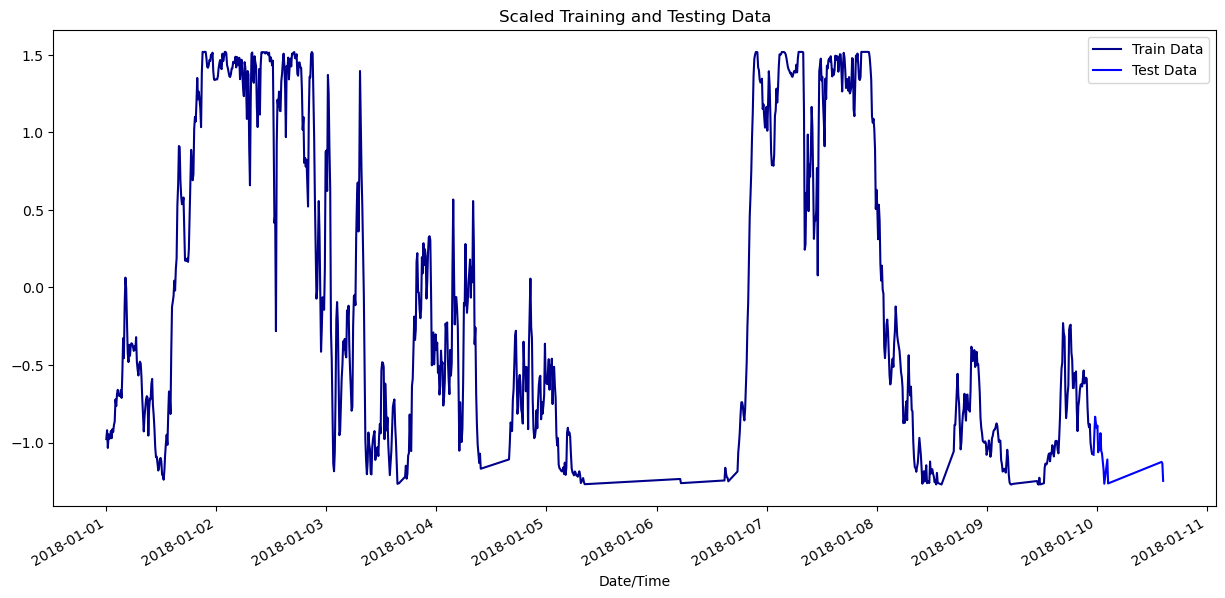

In [38]:
# Convert the scaled data back to Pandas Series for plotting
train_scaled_series_s = pd.Series(train_scaled_Base_s.flatten(), index=train_s.index)
test_scaled_series_s = pd.Series(test_scaled_Base_s.flatten(), index=test_s.index)

# Plot the scaled training and testing data
plt.figure(figsize=(15, 7))
train_scaled_series_s.plot(color='darkblue', label='Train Data')
test_scaled_series_s.plot(color='blue', label='Test Data')
plt.title('Scaled Training and Testing Data')
plt.legend()
plt.show()

In [39]:
# Initiate and fit the model
model_Base_s=ARIMA(train_scaled_Base_s , order=(2,0,1))
model_fit_Base_s=model_Base_s.fit()
print(model_fit_Base_s.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 340.259
Date:                Thu, 23 May 2024   AIC                           -670.518
Time:                        12:28:45   BIC                           -645.980
Sample:                             0   HQIC                          -661.192
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1003      0.357     -0.281      0.779      -0.799       0.599
ar.L1          0.9224      0.210      4.391      0.000       0.511       1.334
ar.L2          0.0585      0.207      0.282      0.7

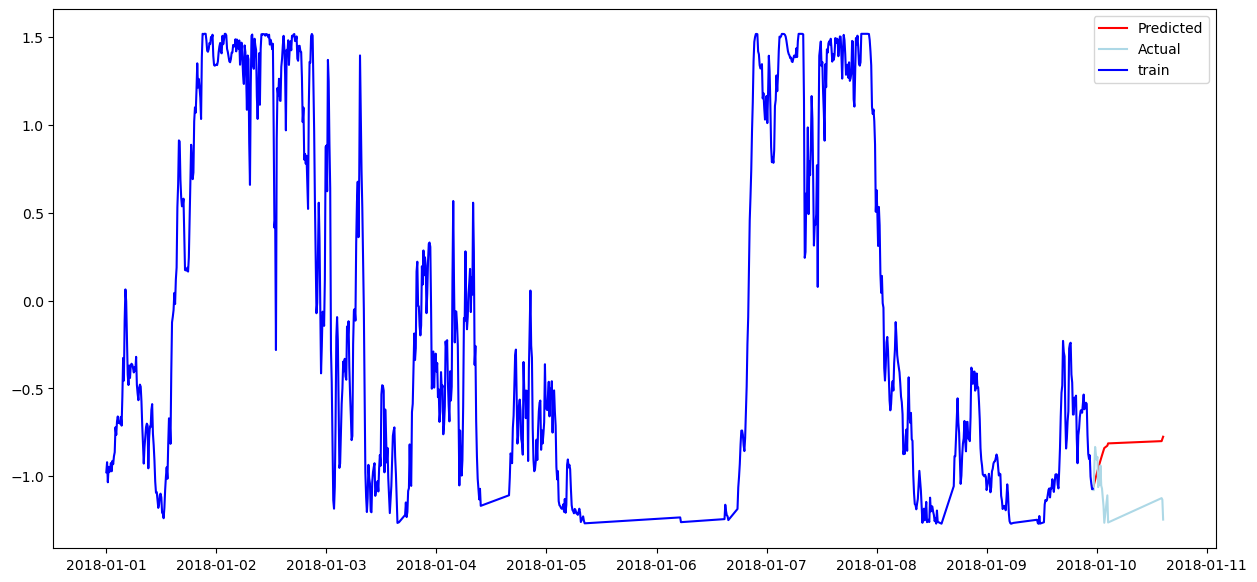

In [40]:
# Predicting values for the test data
predicted_values_s = model_fit_Base_s.forecast(steps=len(test_scaled_Base_s))
predicted_values_series_s = pd.Series(predicted_values_s.flatten(), index=test_s.index)
#train_scaled_series = pd.Series(train_scaled_Base.flatten(), index=train.index)
#test_scaled_series = pd.Series(test_scaled_Base.flatten(), index=test.index)
#predicted_values_series.index = test_scaled_series.index
# Plotting predicted and actual values
plt.figure(figsize =(15,7))
plt.plot(predicted_values_series_s, label='Predicted' , color ='red')
plt.plot(test_scaled_series_s, label='Actual', color = 'lightblue')
plt.plot(train_scaled_series_s ,label = 'train', color = 'blue')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
mae = mean_absolute_error(test_scaled_Base_s,predicted_values_s)
mape = mean_absolute_percentage_error(test_scaled_Base_s,predicted_values_s)
rmse = np.sqrt(mean_squared_error(test_scaled_Base_s,predicted_values_s))
print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae : 0.20673216815735596
mape : 0.1863041506856456
rmse : 0.24937827557592313


The metrics have improved noticeably. I'll maintain this train-test split for the subsequent modeling.

### Model_1  ARIMA(2,1,1)
- Adding differencing to the baseline model. d = 1

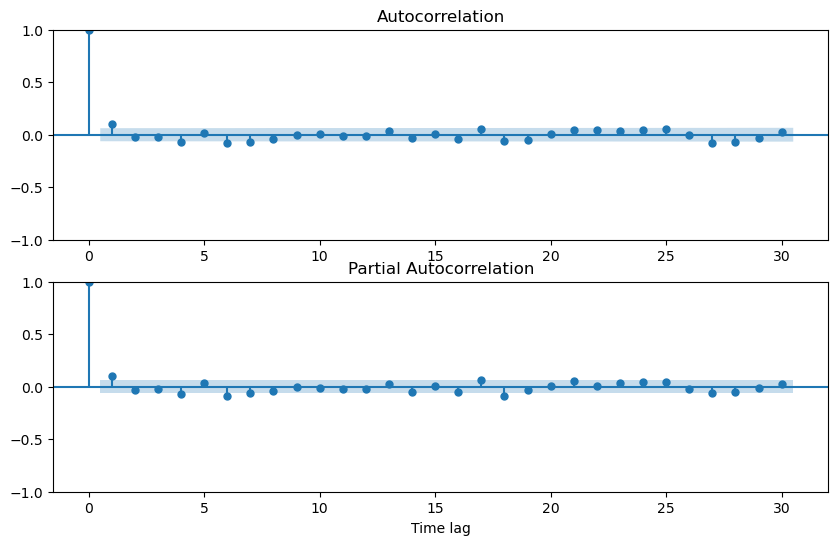

In [42]:
#Analysis of ACF and PACF on differece active power
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_scaled_series_s.diff().dropna(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_scaled_series_s.diff().dropna(), lags=30, ax=ax2)
plt.xlabel('Time lag')
plt.show()

In [43]:
model_2=ARIMA(train_scaled_series_s.diff().dropna(),order=(2,1,1))
model_fit_2=model_2.fit()
print(model_fit_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 332.970
Date:                Thu, 23 May 2024   AIC                           -657.939
Time:                        12:28:47   BIC                           -638.316
Sample:                             0   HQIC                          -650.480
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1086      0.019      5.826      0.000       0.072       0.145
ar.L2         -0.0274      0.023     -1.214      0.225      -0.072       0.017
ma.L1         -1.0000      0.932     -1.073      0.2

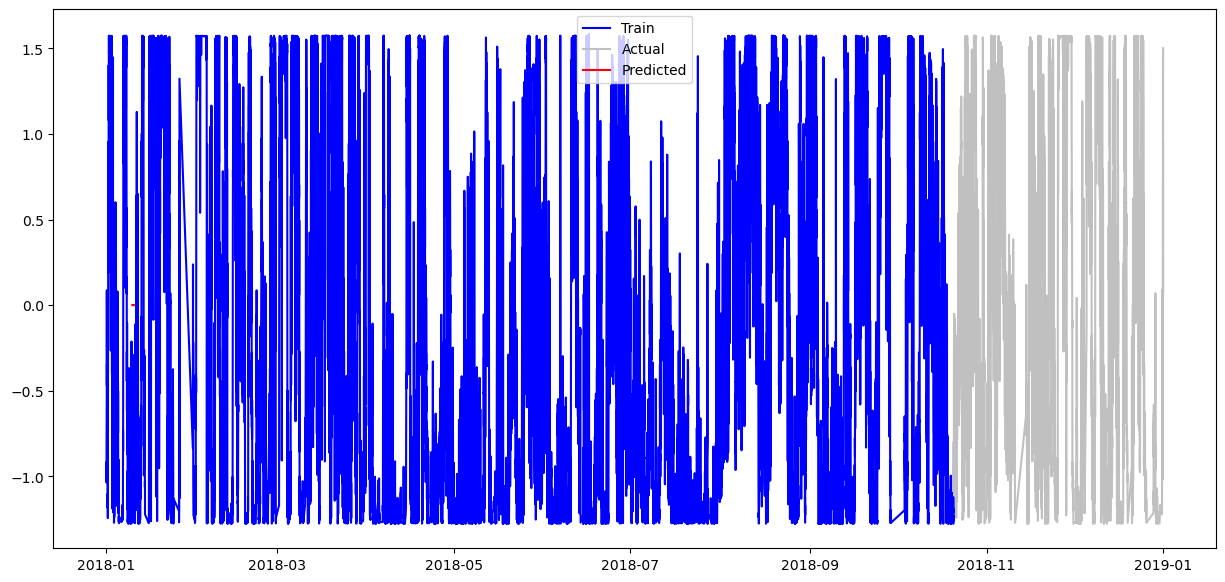

In [44]:
# Predicting values for the test data
predicted_values_1 = model_fit_2.forecast(steps=len(test_scaled_Base_s))
predicted_values_series_1 = pd.Series(predicted_values_1)
predicted_values_series_1.index = test_s.index
# Plotting predicted and actual values
plt.figure(figsize=(15, 7))
plt.plot(train_scaled_series, label='Train', color='blue')
plt.plot(test_scaled_series, label='Actual', color='silver')
plt.plot(predicted_values_series_1, label='Predicted', color='red')
plt.legend()
plt.show()

In [45]:
mae = mean_absolute_error(test_s,predicted_values_series_1)
mape = mean_absolute_percentage_error(test_s,predicted_values_series_1)
rmse = np.sqrt(mean_squared_error(test_s,predicted_values_series_1))
print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae : 277.87296185558785
mape : 1.0000010723624795
rmse : 322.02227235268526


### Manually tuning hyperparameter

In [46]:
class ARIMAWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1,0,0)):
        self.order = order
    
    def fit(self, X, y):
        self.model = ARIMA(y, order=self.order)
        self.model_fit = self.model.fit()
        return self
    
    def predict(self, X):
        return self.model_fit.forecast(steps=len(X))

In [47]:
pipeline = Pipeline([
    ('arima', ARIMAWrapper())
])

In [48]:
param_grid = {
    'arima__order': [(p, d, q) for p in range(4) for d in range(2) for q in range(3)]
}

In [49]:
# Perform TimeSeriesSplit cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [50]:
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(train_s.values.reshape(-1, 1), train_s)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('arima', ARIMAWrapper())]),
             param_grid={'arima__order': [(0, 0, 0), (0, 0, 1), (0, 0, 2),
                                          (0, 1, 0), (0, 1, 1), (0, 1, 2),
                                          (1, 0, 0), (1, 0, 1), (1, 0, 2),
                                          (1, 1, 0), (1, 1, 1), (1, 1, 2),
                                          (2, 0, 0), (2, 0, 1), (2, 0, 2),
                                          (2, 1, 0), (2, 1, 1), (2, 1, 2),
                                          (3, 0, 0), (3, 0, 1), (3, 0, 2),
                                          (3, 1, 0), (3, 1, 1), (3, 1, 2)]},
             scoring='neg_mean_squared_error', verbose=1)

In [51]:
# Get best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters:", best_params)

Best parameters: {'arima__order': (1, 0, 0)}


### Model_2 using arima(1,0,0)

In [52]:
model_Base_bst1=ARIMA(train_scaled_Base_s , order=(1,0,0))
model_fit_Base_bst1=model_Base_bst1.fit()
print(model_fit_Base_bst1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 333.662
Date:                Thu, 23 May 2024   AIC                           -661.325
Time:                        12:29:20   BIC                           -646.601
Sample:                             0   HQIC                          -655.729
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1191      0.377     -0.315      0.752      -0.859       0.621
ar.L1          0.9850      0.008    128.393      0.000       0.970       1.000
sigma2         0.0299      0.001     43.364      0.0

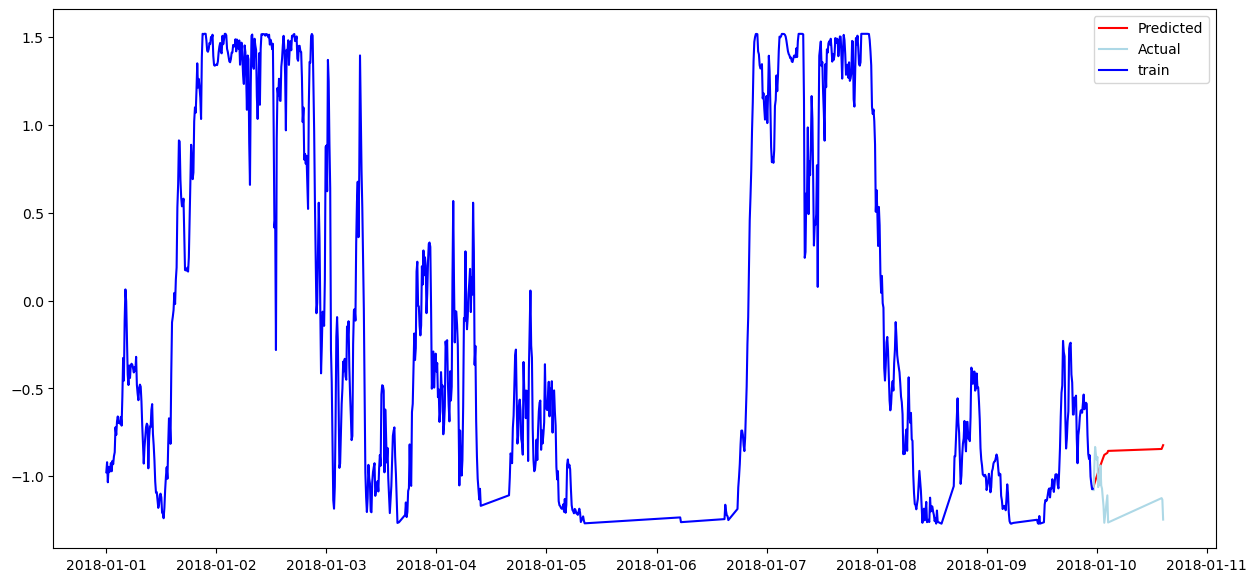

In [53]:
# Predicting values for the test data
predicted_values_bst1 = model_fit_Base_bst1.forecast(steps=len(test_scaled_Base_s))
predicted_values_series_bst1= pd.Series(predicted_values_bst1.flatten(), index=test_s.index)
#train_scaled_series = pd.Series(train_scaled_Base.flatten(), index=train.index)
#test_scaled_series = pd.Series(test_scaled_Base.flatten(), index=test.index)
#predicted_values_series.index = test_scaled_series.index
# Plotting predicted and actual values
plt.figure(figsize =(15,7))
plt.plot(predicted_values_series_bst1, label='Predicted' , color ='red')
plt.plot(test_scaled_series_s, label='Actual', color = 'lightblue')
plt.plot(train_scaled_series_s ,label = 'train', color = 'blue')
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
mae = mean_absolute_error(test_scaled_Base_s,predicted_values_bst1)
mape = mean_absolute_percentage_error(test_scaled_Base_s,predicted_values_bst1)
rmse = np.sqrt(mean_squared_error(test_scaled_Base_s,predicted_values_bst1))
print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae : 0.18493311307113433
mape : 0.16760939672362146
rmse : 0.2232305638723414


### Auto_Arima hyperparameter tunning

In [55]:
# Fit auto_arima function
stepwise_fit = auto_arima(df_copy['LV ActivePower (kW)'], 
                          
                          seasonal=False, 
                           stepwise=False)

# Print the summary of the fitted model
print(stepwise_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                39692
Model:               SARIMAX(3, 1, 2)   Log Likelihood             -277875.602
Date:                Thu, 23 May 2024   AIC                         555765.203
Time:                        12:37:56   BIC                         555825.325
Sample:                             0   HQIC                        555784.240
                              - 39692                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0543      0.157      0.345      0.730      -0.254       0.363
ar.L1          0.8202      0.062     13.243      0.000       0.699       0.942
ar.L2         -0.0658      0.045     -1.471      0.1

### Model_3 Hyperparametr tunning using Auto_arima 

In [56]:
model_Base_bst2=ARIMA(train_scaled_Base_s , order=(3,1,2))
model_fit_Base_bst2=model_Base_bst2.fit()
print(model_fit_Base_bst2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 344.759
Date:                Thu, 23 May 2024   AIC                           -677.518
Time:                        12:38:01   BIC                           -648.077
Sample:                             0   HQIC                          -666.328
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0601      0.074      0.815      0.415      -0.084       0.205
ar.L2          0.7986      0.073     10.920      0.000       0.655       0.942
ar.L3         -0.1029      0.028     -3.711      0.0

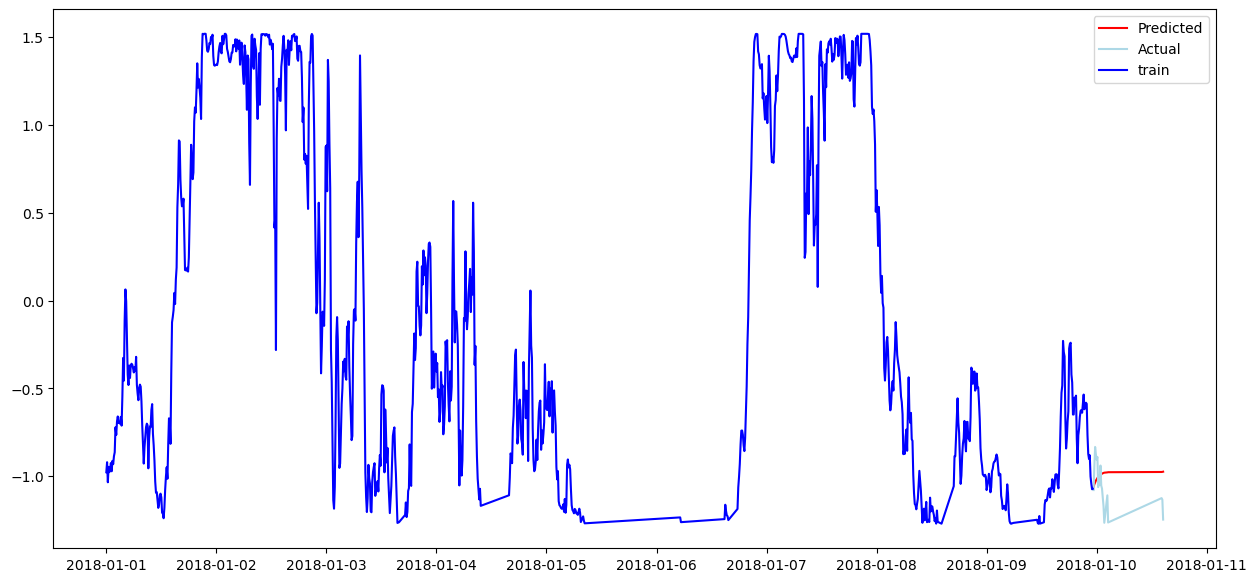

In [57]:
# Predicting values for the test data
predicted_values_bst2 = model_fit_Base_bst2.forecast(steps=len(test_scaled_Base_s))
predicted_values_series_bst2= pd.Series(predicted_values_bst2.flatten(), index=test_s.index)
#train_scaled_series = pd.Series(train_scaled_Base.flatten(), index=train.index)
#test_scaled_series = pd.Series(test_scaled_Base.flatten(), index=test.index)
#predicted_values_series.index = test_scaled_series.index
# Plotting predicted and actual values
plt.figure(figsize =(15,7))
plt.plot(predicted_values_series_bst2, label='Predicted' , color ='red')
plt.plot(test_scaled_series_s, label='Actual', color = 'lightblue')
plt.plot(train_scaled_series_s ,label = 'train', color = 'blue')
plt.legend()
plt.show()

In [58]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
mae = mean_absolute_error(test_scaled_Base_s,predicted_values_bst2)
mape = mean_absolute_percentage_error(test_scaled_Base_s,predicted_values_bst2)
rmse = np.sqrt(mean_squared_error(test_scaled_Base_s,predicted_values_bst2))
print(f'mae : {mae}')
print(f'mape : {mape}')
print(f'rmse : {rmse}')

mae : 0.13162599893754348
mape : 0.12245984700173755
rmse : 0.1547621523674663


Among the models evaluated thus far, this particular model stands out as the most promising based on its performance across various metrics. Its superior performance suggests that it may offer the most accurate predictions compared to the other models assessed.

#### Logistic Regression Model

The time series analysis was satisfactory for short-term forecasting. Now, let's evaluate another model, specifically logistic regression, to assess the performance of the wind turbine power output compared to the theoretical power.To do that we need to create the Target column, which is the ratio of the LV Activepower and Theoretical_power_curve.

In [59]:
# Create Target column
df['Target'] = (df['LV ActivePower (kW)']/df['Theoretical_Power_Curve (KWh)'])*100

In [60]:
# Drop null values
df.dropna(axis = 1, inplace = True)

In [61]:
#Filter out the negative and zero theoretical_power_curve (Kwh)
filtered_df_2 = df[df['Theoretical_Power_Curve (KWh)'] <= 0]

In [62]:
# Drop negative and zero Theoretical_Power_Curve (KWh)
df.drop(filtered_df_2.index , inplace =True )

In [63]:
# Filter some outliers with Target > 150%
filtered_df_3 = df[df['Target'] >= 150]

In [64]:
# Drop Target over 150% can be assumed as outlier
df.drop(filtered_df_3.index , inplace =True )

In [65]:
# Classifiy the Target column in to binary out put if Target is greater or equal to 90% it well performing  or Just 1.
# And if it is less than 90% it is underperforming or 0.
df['Target'] = df['Target'].apply(lambda x: 1 if x >= 90 else 0)

In [66]:
df.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Week,Day,Hour,Seasons,Target
Date/Time,,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,1,1,1,Winter,1
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,1,1,1,Winter,0
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,1,1,1,Winter,0
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,1,1,1,Winter,0
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,1,1,1,Winter,0


In [67]:
# Check value count on the Target column
df['Target'].value_counts()

Target
0    19525
1    19452
Name: count, dtype: int64

As we can see, the target variable is well-balanced. Our data is now ready for preprocessing and modeling.

In [68]:
# Import the necessary libraries to do the logistic regression model.
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [69]:
# Define numerical, categorical, and other features
num_features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
cat_features = ['Seasons']
other_features = ['Month','Week','Day','Hour']

# Splitting the data into features and target
X = df[num_features + cat_features + other_features]
y = df['Target']  

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
# Defining the column transformer with one-hot encoding for categorical features and standard scaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features + other_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

In [71]:
# Creating the pipeline with logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [72]:
# Defining the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l1', 'l2']
}

# Setting up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fitting the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['LV '
                                                                          'ActivePower '
                                                                          '(kW)',
                                                                          'Wind '
                                                                          'Speed '
                                                                          '(m/s)',
                                                                          'Theoretical_Power_Curve '
                                                                          '(KWh)',
                                                                          'Wind '
                                                                          'Direction '
                                                                          '(°)',
                                                                          'Month',
                                                                          'Week',
                                                                          'Day',
                                                                          'Hour']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Seasons'])])),
                                       ('classifier',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'classifier__C': [0.1, 1.0, 10.0],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [73]:
# Printing the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1'}


In [74]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', C=10.0, penalty='l1'))
])

In [75]:
# Fitting the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['LV ActivePower (kW)',
                                                   'Wind Speed (m/s)',
                                                   'Theoretical_Power_Curve '
                                                   '(KWh)',
                                                   'Wind Direction (°)',
                                                   'Month', 'Week', 'Day',
                                                   'Hour']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Seasons'])])),
                ('classifier',
                 LogisticRegression(C=10.0, penalty='l1', solver='liblinear'))])

In [76]:
y_pre = pipeline.predict(X_test)

In [77]:
# Evaluating the model on the test set
test_score = pipeline.score(X_test, y_test)
print(f"Test Set Score: {test_score}")

Test Set Score: 0.996023601847101


The logistic regression model achieved an impressive accuracy of 99%, indicating a high level of precision in predicting the performance of the wind turbine power output compared to the theoretical power. This suggests that the model is highly effective and reliable for this classification task, successfully distinguishing between well-performing and underperforming power outputs with minimal error.

#### Conclusion 


The time series power analysis model using ARIMA(3,1,2) demonstrated strong capabilities for short-term forecasting, providing good predictions and  achieving a mean absolute error of 13%. However, when applied to long-term forecasting, the model fell short, This suggests that the ARIMA model struggles with capturing the complexities and variabilities inherent in long-term data. To address this limitation, it is necessary to explore more advanced modeling techniques that can better handle long-term dependencies and non-linear patterns in the data.

In contrast, the logistic regression model exhibited excellent performance in classifying wind energy output relative to theoretical expectations. With an impressive accuracy score of 99%, the logistic regression model proved highly effective in identifying whether the wind turbine's actual power output was within an acceptable range of its theoretical power curve. This high level of accuracy indicates that logistic regression is a robust tool for assessing wind turbine performance, providing reliable insights that can inform operational and maintenance decisions.

Overall, while ARIMA remains a valuable tool for short-term forecasting, its limitations for long-term predictions highlight the need for more sophisticated models. Meanwhile, logistic regression has proven to be a powerful method for evaluating wind energy performance, offering high accuracy and reliability. Further research and model development are recommended to enhance long-term forecasting accuracy and continue improving wind energy performance assessment.